## Importing dependencies and setting file paths

In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import random
import os
import glob
import cv2 
from fastai.vision import *
from fastai import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import plot_confusion_matrix


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {device}')


Running on device: cuda:0


In [2]:
# Set seed fol all
def seed_everything(seed=1358):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

In [3]:
PATH = Path('../input/planets-dataset/planet/planet/')
train_img = PATH/'train-jpg'
train_folder = 'train-jpg'
test_img = PATH/'test-jpg'
model_dir = Path('/kaggle/working/')
bs = 64

In [4]:
PATH.ls()

[PosixPath('../input/planets-dataset/planet/planet/sample_submission.csv'),
 PosixPath('../input/planets-dataset/planet/planet/test-jpg'),
 PosixPath('../input/planets-dataset/planet/planet/train_classes.csv'),
 PosixPath('../input/planets-dataset/planet/planet/train-jpg')]

## Little bit of EDA

In [5]:
train_df = pd.read_csv(os.path.join(PATH, 'train_classes.csv'))
# adding path to the image in our dataframe. 
train_df['image_name'] = train_df['image_name'].apply(lambda x: f'{train_folder}/{x}.jpg')
train_df.head()

,image_name,tags
0,train-jpg/train_0.jpg,haze primary
1,train-jpg/train_1.jpg,agriculture clear primary water
2,train-jpg/train_2.jpg,clear primary
3,train-jpg/train_3.jpg,clear primary
4,train-jpg/train_4.jpg,agriculture clear habitation primary road


> We have 17 unique labels for this data

In [6]:
# Since this is a multi lable task and the labels are given as tags in a single dataframe series
biner = MultiLabelBinarizer()
tags = train_df['tags'].str.split()
y = biner.fit_transform(tags)

labels = biner.classes_
print('Number of labels: ', len(labels))
print(labels)

Number of labels:  17
['agriculture' 'artisinal_mine' 'bare_ground' 'blooming' 'blow_down' 'clear' 'cloudy' 'conventional_mine' 'cultivation'
 'habitation' 'haze' 'partly_cloudy' 'primary' 'road' 'selective_logging' 'slash_burn' 'water']


In [7]:
# Getting the labels into one hot encoded form for EDA ease. 
for label in labels:
    train_df[label] = train_df['tags'].apply(lambda x: 1 if label in x.split()  else 0)
    
train_df.head()

,image_name,tags,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,train-jpg/train_0.jpg,haze primary,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,train-jpg/train_1.jpg,agriculture clear primary water,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,train-jpg/train_2.jpg,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,train-jpg/train_3.jpg,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,train-jpg/train_4.jpg,agriculture clear habitation primary road,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0


The label primary appears the most in our dataset followed by clear and agriculture. 
As stated in the data description, primary refers to primary rainforest.
> Generally speaking, the "primary" label was used for any area that exhibited dense tree cover. 

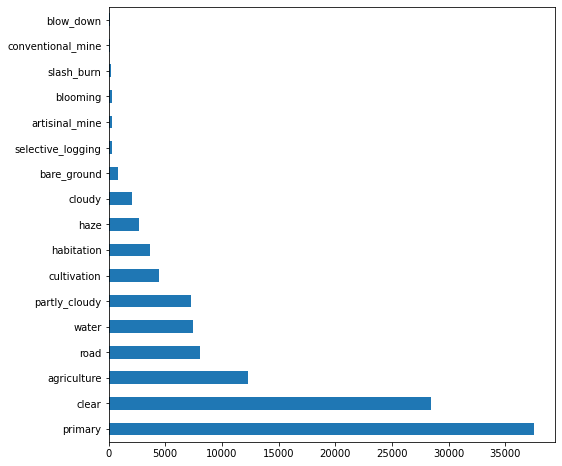

In [8]:
train_df[labels].sum().sort_values(ascending=False).plot(kind='barh', figsize=(8,8))

Looking at the co-ocurrance for these labels. 
> The combination (primary, clear) has the highest co-ocurrance. Followed by (primary, agriculture)

In [9]:
df_asint = train_df.drop(train_df.columns[[0,1]], axis=1).astype(int)
coocc_df = df_asint.T.dot(df_asint)

coocc_df

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
agriculture,12315,38,225,32,22,9150,0,24,3377,2737,672,2493,11972,6034,65,119,2712
artisinal_mine,38,339,40,0,0,307,0,4,18,29,5,27,324,110,6,0,299
bare_ground,225,40,862,3,4,747,0,10,89,163,41,74,683,323,13,10,206
blooming,32,0,3,332,1,311,0,0,35,4,4,17,332,10,7,2,16
blow_down,22,0,4,1,98,85,0,0,8,3,0,13,98,2,1,2,3
clear,9150,307,747,311,85,28431,0,70,3527,3090,0,0,27668,6295,308,173,5502
cloudy,0,0,0,0,0,0,2089,0,0,0,0,0,0,0,0,0,0
conventional_mine,24,4,10,0,0,70,0,100,4,36,2,28,94,59,0,0,26
cultivation,3377,18,89,35,8,3527,0,4,4477,895,202,748,4455,1294,58,126,868
habitation,2737,29,163,4,3,3090,0,36,895,3660,129,441,3469,2786,13,41,915


In [10]:
# Confusion matrix. 

Plotting a few random images with there labels to see how the data looks. 
Choose 10 random images from the data. 

In [11]:
#reading images

random_imgs = train_df.ix[random.sample(list(train_df.index), 10)][['image_name', 'tags']]

to_read = random_imgs.loc[:, 'image_name'].values
tags = random_imgs.loc[:, 'tags'].values

images = [cv2.imread(os.path.join(PATH/file)) for file in to_read]
print("Number of images: ", len(images))
print("Size of an image: ", images[0].shape)

Number of images:  10
Size of an image:  (256, 256, 3)


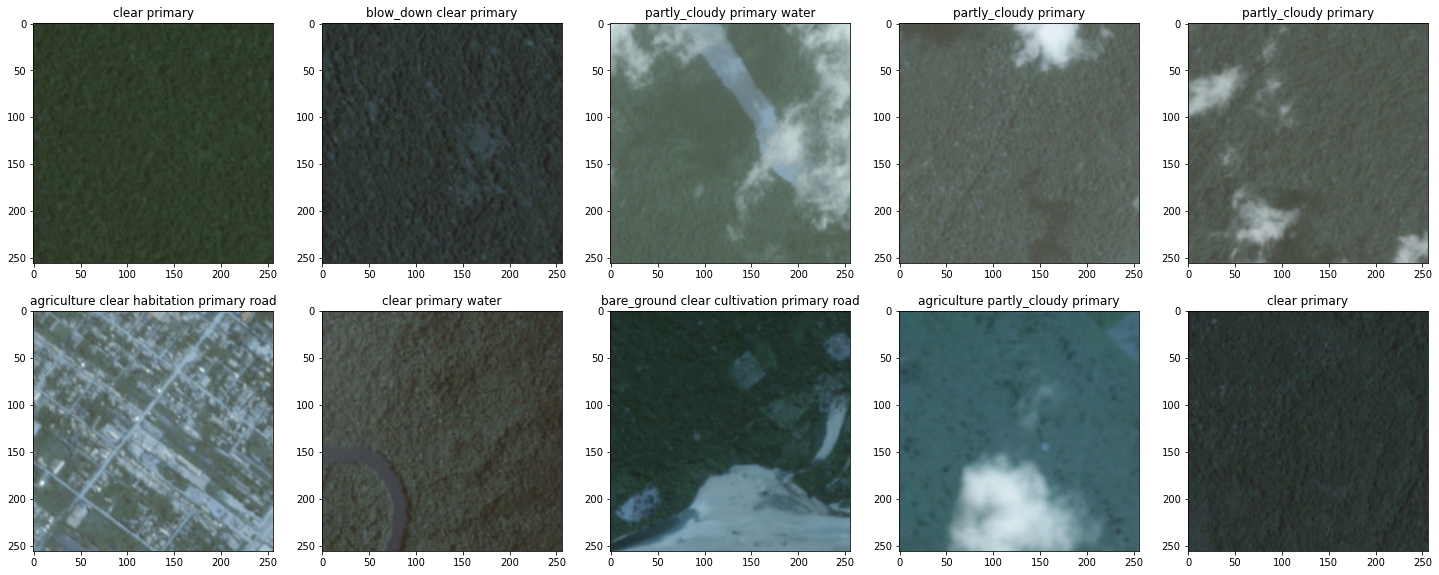

In [12]:
plt.figure(figsize=(25,15))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.grid(False)
    plt.title(tags[i])

## Training 

Using the usual fast ai to train and evaluate models. 

In [13]:
print(f"Size of Training set images: {len(list(train_img.glob('*.jpg')))}")
print(f"Size of Test set images: {len(list(test_img.glob('*.jpg')))}")


Size of Training set images: 40479
Size of Test set images: 40669


Starting with an image size of 128*128 with a few transformations. 
+ Flipping the image vertically and horizontaly. 
+ Changing lighting and contrast. 
+ Rotations. 
+ Zooming. 

In [14]:
img_size = 128

tfms = get_transforms(do_flip=True,flip_vert=True,p_lighting=0.4,
                      max_lighting=0.3, max_zoom=1.05, max_rotate=360, xtra_tfms=[flip_lr()])


# The datablock API makes things very easy. 
# Im using 1% of the training data to validate the models. 

src = (ImageList.from_df(train_df, PATH, cols='image_name')
        .split_by_rand_pct(valid_pct=0.1)
        .label_from_df(label_delim=' '))


data = (src.transform(tfms,size=img_size,resize_method=ResizeMethod.CROP)
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)      
       )

36432 images for training and 4047 for validating. 

In [15]:
data

ImageDataBunch;

Train: LabelList (36432 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
haze;primary,agriculture;clear;primary;water,clear;primary,clear;primary,agriculture;clear;habitation;primary;road
Path: ../input/planets-dataset/planet/planet;

Valid: LabelList (4047 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
partly_cloudy;primary,partly_cloudy;primary,clear;primary;water,agriculture;clear;primary;water,partly_cloudy;primary
Path: ../input/planets-dataset/planet/planet;

Test: None

Train data has 36432 images of size 128x128x3. 

In [16]:
data.train_ds

LabelList (36432 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
haze;primary,agriculture;clear;primary;water,clear;primary,clear;primary,agriculture;clear;habitation;primary;road
Path: ../input/planets-dataset/planet/planet

In [17]:
data.valid_ds

LabelList (4047 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
partly_cloudy;primary,partly_cloudy;primary,clear;primary;water,agriculture;clear;primary;water,partly_cloudy;primary
Path: ../input/planets-dataset/planet/planet

In [18]:
data.train_ds[0]

(Image (3, 128, 128), MultiCategory haze;primary)

A random point from the databunch. 
This time i select the labels from **data.train_ds.y** and image from **data.train_ds.x**

The databunch containing the train dataset has both x and y components and we can index into them. 

agriculture;clear;primary


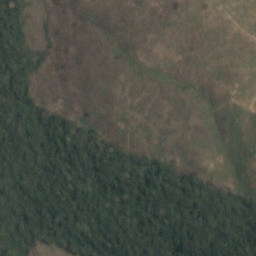

In [19]:
print(data.train_ds.y[200])
data.train_ds.x[200]

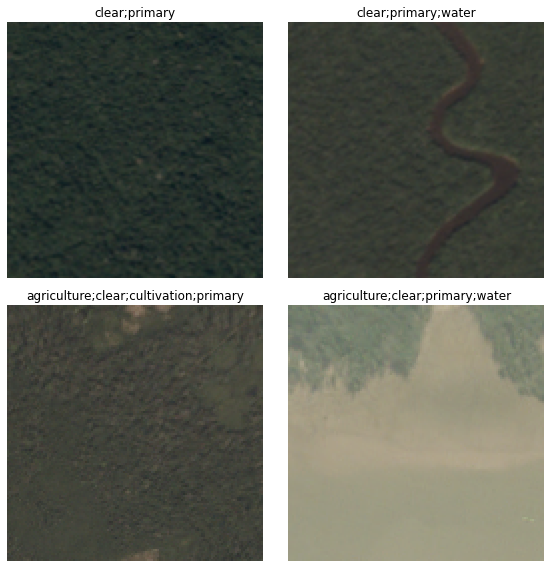

In [20]:
data.show_batch(rows=2)

> Every experiment would have two stages: 
+ 1st stage: Freezing early layers and only fine-tuning the last few newly added layers.
+ 2nd stage: Unfreezing all the layers and fine-tuning them. 


## Train Kernel 1

> For the first kernel: 
> + Using resnet50 (pretrained on imagenet)
> + fbeta with 0.2 threshold and accuracy as metrics. 


In [21]:
model_1 = models.resnet50
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

learn = create_cnn(data, model_1, metrics=[acc_02, f_score], model_dir='/kaggle/working')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


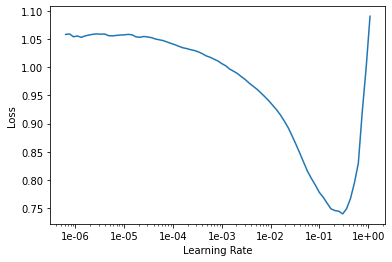

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(5, 0.01)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.130628,0.125457,0.931395,0.888289,04:39
1,0.123415,0.120977,0.944403,0.888204,04:10
2,0.110703,0.101240,0.951395,0.905895,04:11
3,0.101818,0.092485,0.954127,0.916651,04:11
4,0.095626,0.089801,0.954621,0.922378,04:10


With 5 epochs able to get upto 92% fbeta. 

In [24]:
learn.model_dir = '/kaggle/working'
learn.save('resnet50-stage1')

## Train Kernel 2

> For the second train kernel:
+ Using DenseNet121 (pretrained on imagenet)
+ Similar metrics as first experiment. 

Fine-tuning last layers in Stage 1 

In [25]:
model_2 = models.densenet121
learn_dense = create_cnn(data, model_2, metrics=[acc_02, f_score], model_dir='/kaggle/working')

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth


In [26]:
learn_dense.fit_one_cycle(5, 0.01)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.136225,0.132083,0.934214,0.887571,04:44
1,0.117498,0.108966,0.941089,0.905916,04:44
2,0.108108,0.096676,0.949912,0.915863,04:44
3,0.098900,0.091861,0.954810,0.917398,04:44
4,0.095757,0.088160,0.955043,0.923050,04:43


DenseNet201 performs slighly better than resnet50. 
I ll use this for fine tuning the entire model. 

In [27]:
learn_dense.save('DenseNet121-stage1')

Fine-tuning the entire model in stage 2. 

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


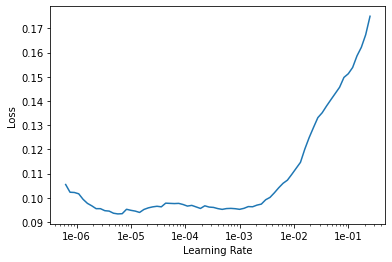

In [28]:
learn_dense.unfreeze()
learn_dense.lr_find()
learn_dense.recorder.plot()

In [29]:
learn_dense.fit_one_cycle(5, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.095843,0.088985,0.954868,0.921441,04:55
1,0.093876,0.087582,0.955159,0.924172,04:53
2,0.094727,0.087501,0.954316,0.922810,04:53
3,0.093677,0.086876,0.955116,0.924442,04:53
4,0.092216,0.086991,0.955959,0.924351,04:53


In [30]:
learn_dense.save('DenseNet121-stage2')

## Train Kernel 3

Fine tuning the network further with larger image size. 

In [31]:
data_2 = (src.transform(tfms,size=256,resize_method=ResizeMethod.CROP)
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)      
       )

data_2

ImageDataBunch;

Train: LabelList (36432 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
haze;primary,agriculture;clear;primary;water,clear;primary,clear;primary,agriculture;clear;habitation;primary;road
Path: ../input/planets-dataset/planet/planet;

Valid: LabelList (4047 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
partly_cloudy;primary,partly_cloudy;primary,clear;primary;water,agriculture;clear;primary;water,partly_cloudy;primary
Path: ../input/planets-dataset/planet/planet;

Test: None

In [32]:
model_2 = models.densenet121
learn_dense_2 = create_cnn(data_2, model_2, metrics=[acc_02, f_score], model_dir='/kaggle/working')

In [33]:
learn_dense_2.load('DenseNet121-stage2')

Learner(data=ImageDataBunch;

Train: LabelList (36432 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
haze;primary,agriculture;clear;primary;water,clear;primary,clear;primary,agriculture;clear;habitation;primary;road
Path: ../input/planets-dataset/planet/planet;

Valid: LabelList (4047 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
partly_cloudy;primary,partly_cloudy;primary,clear;primary;water,agriculture;clear;primary;water,partly_cloudy;primary
Path: ../input/planets-dataset/planet/planet;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


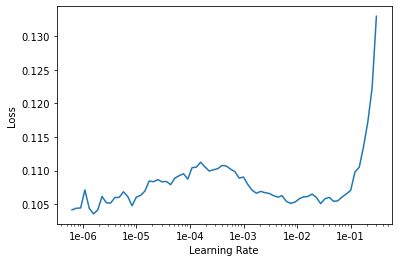

In [34]:
learn_dense_2.lr_find()
learn_dense_2.recorder.plot()

In [35]:
learn_dense_2.fit_one_cycle(10, 0.01)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.095023,0.092137,0.954970,0.916278,08:00
1,0.102423,0.098788,0.957354,0.913738,08:00
2,0.107599,0.099211,0.952499,0.911263,08:01
3,0.106485,0.092724,0.955799,0.918801,08:02
4,0.102313,0.091831,0.954621,0.920626,08:02
5,0.099105,0.109260,0.953895,0.918046,08:00
6,0.095624,0.088250,0.955566,0.923355,08:03
7,0.091193,0.086144,0.954752,0.923723,08:02
8,0.089872,0.086524,0.956409,0.924017,08:02
9,0.087986,0.085989,0.956744,0.924238,08:02


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


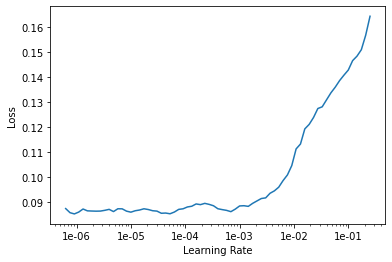

In [36]:
learn_dense_2.unfreeze()
learn_dense_2.lr_find()
learn_dense_2.recorder.plot()

In [37]:
learn_dense_2.fit_one_cycle(10, slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.089215,0.084999,0.956904,0.925127,08:26
1,0.091177,0.086199,0.956409,0.923261,08:23
2,0.089894,0.084674,0.956874,0.925259,08:24
3,0.089014,0.089483,0.955988,0.923907,08:24
4,0.087098,0.085045,0.956845,0.924803,08:24
5,0.087004,0.085441,0.957092,0.923138,08:16
6,0.087072,0.084916,0.956613,0.923503,08:15
7,0.086334,0.084625,0.956932,0.924650,08:18
8,0.087664,0.085326,0.957412,0.924003,08:22
9,0.084294,0.084419,0.956656,0.924459,08:21
